In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.linear_model import Lasso
import optuna
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics

from sklearn import set_config
set_config(transform_output = "pandas")

In [4]:
df = pd.read_csv("/content/glassdoor_jobs_eda.csv")

In [5]:
df.columns

Index(['Location', 'Headquarters', 'Type of ownership', 'Industry', 'Rating',
       'Sector', 'hourly', 'avr_salary', 'company_txt', 'age', 'job_state',
       'same_state', 'python_yn', 'R_yn', 'sql_yn', 'excel_yn', 'job_title',
       'seniority', 'desc_len', 'num_comp', 'employees_num', 'revenue_avr'],
      dtype='object')

In [6]:
# missing values count
print(df.shape)

missing_val_count_by_column = (df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(615, 22)
revenue_avr    163
dtype: int64


In [7]:
# select X and y from dataframe
X = df.drop("avr_salary", axis=1)
y = df["avr_salary"].to_numpy()

In [8]:
# Select categorical columns
categorical_cols = [cname for cname in X.columns if
                    X[cname].nunique() < float("inf") and
                    X[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X.columns if
                  X[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X = X[my_cols]

print(f"num: {numerical_cols}")
print(f"cat: {categorical_cols}")

num: ['Rating', 'hourly', 'age', 'desc_len', 'num_comp', 'employees_num', 'revenue_avr']
cat: ['Location', 'Headquarters', 'Type of ownership', 'Industry', 'Sector', 'company_txt', 'job_state', 'job_title', 'seniority']


In [9]:
X[categorical_cols].nunique()

Location             171
Headquarters         161
Type of ownership      9
Industry              53
Sector                22
company_txt          281
job_state             37
job_title              7
seniority              3
dtype: int64

In [10]:
# delete company_txt
X = X.drop("company_txt", axis=1)
categorical_cols.remove("company_txt")

In [11]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('yeo-johnson', PowerTransformer())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

pipe = Pipeline([("preprocessor", preprocessor)])

In [12]:
# transform X and train/valid/test split
X_prep = pipe.fit_transform(X)

import re
X_prep = X_prep.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [13]:
# model training
def regression_results(y_true, y_pred):

    # Regression metrics
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('r2: ', round(r2, 4))
    print('MAE: ', round(mean_absolute_error, 4))
    print('MSE: ', round(mse, 4))
    print('RMSE: ', round(np.sqrt(mse), 4))

In [34]:
# random forest, xgboost, lgbm
for model in Lasso(), xgb.XGBRegressor(), lgb.LGBMRegressor():
  model.fit(X_train, y_train)

  print("\n\n")
  print(type(model).__name__)
  print("Train results")
  y_pred = model.predict(X_train)
  regression_results(y_train, y_pred)

  print("----------------------------")

  print("Test results")
  y_pred = model.predict(X_val)
  regression_results(y_val, y_pred)




Lasso
Train results
r2:  0.4909
MAE:  19.0781
MSE:  568.4732
RMSE:  23.8427
----------------------------
Test results
r2:  0.5184
MAE:  19.482
MSE:  593.268
RMSE:  24.3571



XGBRegressor
Train results
r2:  0.9955
MAE:  1.581
MSE:  4.9998
RMSE:  2.236
----------------------------
Test results
r2:  0.7197
MAE:  11.4029
MSE:  345.3065
RMSE:  18.5824



LGBMRegressor
Train results
r2:  0.8761
MAE:  7.9773
MSE:  138.3594
RMSE:  11.7626
----------------------------
Test results
r2:  0.6143
MAE:  15.2622
MSE:  475.1132
RMSE:  21.7971


In [19]:
# hyperparameter tuning
def objective(trial):
    dtrain = lgb.Dataset(X_train, label=y_train)

    param = {
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "rf"]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    y_pred = gbm.predict(X_val)

    trial.set_user_attr(key="best_booster", value=gbm)

    mae=metrics.mean_absolute_error(y_val, y_pred)
    mse=metrics.mean_squared_error(y_val, y_pred)
    r2=metrics.r2_score(y_val, y_pred)

    return [mae, mse, r2]


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(directions=["minimize", "minimize", "maximize"])
study.optimize(objective, n_trials=1000)

print("Number of finished trials: ", len(study.trials))
print("Best trials:")
trials = study.best_trials

Number of finished trials:  1000
Best trials:


In [20]:
for trial in trials:
  print(trial.values)

[11.186344942606826, 331.34624743457573, 0.7309987851761057]
[10.721105428451567, 377.87204760898146, 0.6932271282931044]
[11.186344942606826, 331.34624743457573, 0.7309987851761057]
[11.371289905497166, 327.08270762863896, 0.7344601111942116]
[10.896303901668182, 371.30105749594605, 0.6985617422707422]
[11.371289905497166, 327.08270762863896, 0.7344601111942116]
[10.896303901668182, 371.30105749594605, 0.6985617422707422]
[11.371289905497166, 327.08270762863896, 0.7344601111942116]
[11.728558619864174, 324.2172109227788, 0.7367864453564914]


In [21]:
model = trials[0].user_attrs['best_booster']
y_pred = model.predict(X_test)
regression_results(y_test, y_pred)

r2:  0.7501
MAE:  10.4381
MSE:  307.2425
RMSE:  17.5283


In [22]:
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[0])

/usr/local/lib/python3.10/dist-packages/optuna/visualization/_utils.py:67: UserWarning: `target` is specified, but `target_name` is the default value, 'Objective Value'.
  warnings.warn(


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

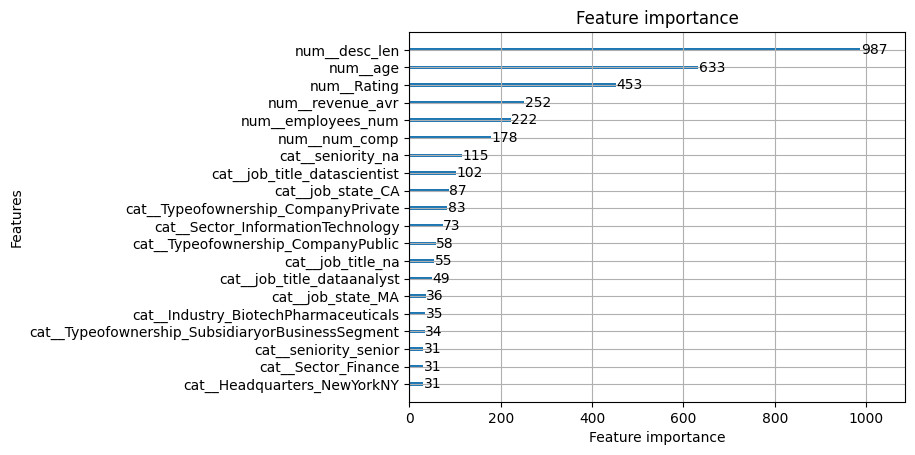

In [23]:
# feature impotance
lgb.plot_importance(model, max_num_features=20)

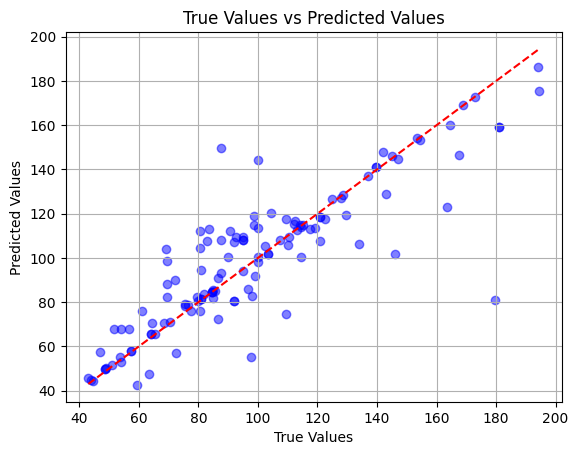

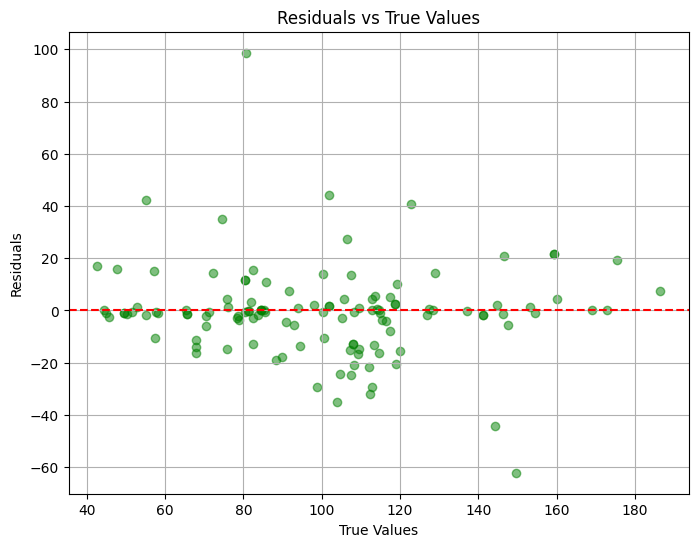

In [27]:
def plot_regression(y_true, y_pred):
    # Calculate residuals
    residuals = y_true - y_pred

    # Plot y_true vs y_pred
    #plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, c='b', alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True Values vs Predicted Values')
    plt.grid(True)
    plt.show()

    # Plot residuals vs y_true
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, c='g', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs True Values')
    plt.grid(True)
    plt.show()


plot_regression(y_test, y_pred)

In [29]:
# save model
import joblib

whole_model = Pipeline(steps=[
    ("prep", pipe),
    ("model", model)
])

joblib.dump(whole_model, "glassdoor_jobs_model.joblib")

['glassdoor_jobs_model.joblib']